# Notebook description

This notebook implements the delta learning rule in NEF by modifying the the activity of neurons rather than their decode weights directly. 

NEF can implement arbitrary dynamical systems (NEF should even be able to implement itself). By formualting the delta learning rule as a dynamical system, we can implement the delta learning rule with standard 'vanilla' NEF. This allows us to say that indeed any chip that implements standard NEF can learn.

# Background

For input $x$, we would like to approximate some function $f(x)$ using a linear combination of $N$ nonlinear functions, $a_i(x)$.

$$f(x)\approx y$$

where

$$y=\sum_i^Nw_ia_i(x)$$

where $w_i$ is the weight of the $i$th nonlinear function. The error of our approximation is defined as

$$e=f(x)-y$$

From here, we'll drop the $(x)$ notation for succictness. 

We define the cost function

$$E=\frac{1}{2}e^2$$

that indicates the quality of our $f(x)$ approximation. When $E=0$ our approximation is perfect. To send $E$ to $0$ over time, we would like a rule such that

$$\frac{dE}{dt}\propto-E$$

which will converge to $E=0$. Now,

\begin{align*}
\frac{dE}{dt} &= \sum_i^N\frac{\partial E}{\partial w_i}\frac{dw_i}{dt} \\
\end{align*}

and

\begin{align*}
\frac{\partial E}{\partial w_i} &= \frac{\partial E}{\partial y}\frac{\partial y}{\partial w_i} \\
 &= -(f-y)\frac{\partial y}{\partial w_i} \\
 &= -(f-y)a_i \\
\end{align*}

Now, we set $\frac{dw_i}{dt}$ to give us the desired $\frac{dE}{dt}$.

\begin{align*}
\frac{dw_i}{dt} &= -\alpha\frac{\partial E}{\partial w_i} \\
 &= \alpha(f-y)a_i \\
\end{align*}

where $\alpha$ is some positive constant. With this $\frac{dw_i}{dt}$,

\begin{align*}
\frac{dE}{dt} &= \sum_i^N\frac{\partial E}{\partial w_i}\frac{dw_i}{dt} \\
 &= \sum_i(-(f-y)a_i)(\alpha(f-y)a_i) \\
 &= -\alpha\sum_i^N(f-y)^2a_i^2 \\
 &= -(2\alpha\sum_i^Na_i^2)E \\ 
 &\propto -E \\
\end{align*}

as we desired because $(2\alpha\sum_i^Na_i^2)$ is nonnegative. 

Note that we can make $e$ follow simple, first-order dynamics if we set 

$$\alpha=\frac{1}{\tau\sum_i^Na_i^2}$$

for some $\tau$ that we would like to govern the system dynamics, we will have 

$$\tau\frac{dE}{dt}=-2E$$

Substituting for $E$,

\begin{align*}
\tau\frac{d}{dt}\frac{1}{2}e^2 &= -e^2 \\
\tau \frac{de}{dt}e &= -e^2 \\
\tau \frac{de}{dt} &= -e \\
\end{align*}

the first-order dynamics we desire.

# Nengo implementation

We'll implement this learning rule in nengo. An example three unit implementation is diagrammed by

<img src="figures/activity_delta.png" alt="Activity based delta learning rule network" style="width: 500px;"/>

 - The $a_i$ circles are 1-neuron ensembles that just decode their tuning curve (scaled so their output values are within the radii of their target ensembles).
 - The $w_i$ circles are ensembles that integrate $\frac{dw_i}{dt}$ to produce $w_i$.
 - The $x$ circles are ensembles that multiply their inputs.
 
It's important to consider where exactly the synaptic filters are. They add dynamics to the system that our original math doesn't consider and are liable to make the system unstable.

<img src="figures/activity_delta_dynamics.png" alt="Activity based delta learning rule network with dynamical elements shown" style="width: 500px;"/>

The synaptic filters are represented with triangles. The synaptic filters used along the inputs to the $w_i$ are not shown because $w_i$ are configured to compensate for the synaptic dyanmics and implement integration.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import nengo
from nengo.utils.ensemble import tuning_curves
from nengo.dists import Uniform, Choice
from matplotlib import pyplot as plt

:0: FutureWarning: IPython widgets are experimental and may change in the future.


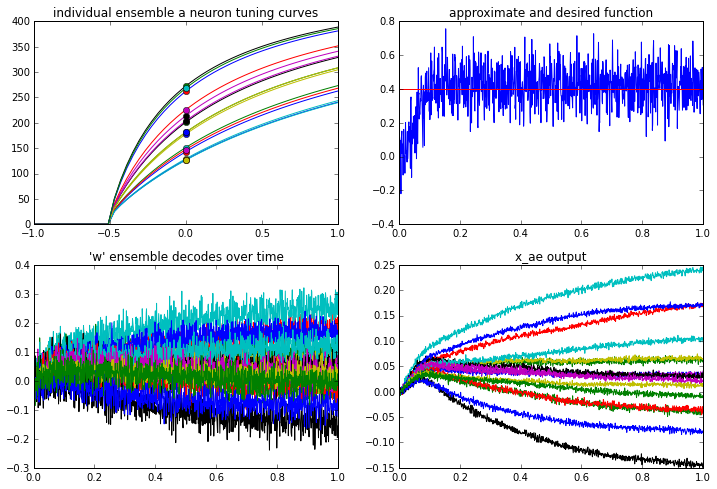

In [6]:
def get_tuning(N, d, nt, intercepts=Uniform(-1., 1.), max_rates=Uniform(200, 400)):
    """Generate the encoders, gain, and bias parameters for an ensemble"""
    net = nengo.Network()
    with net:
        ens = nengo.Ensemble(N, d, neuron_type=nt, intercepts=intercepts, max_rates=max_rates)    
    sim = nengo.Simulator(net)

#     inputs, activities = tuning_curves(ens, sim)
#     fig, ax = plt.subplots()
#     ax.plot(inputs, activities)
#     ax.set_title('ensemble tuning curves')

    enc = sim.data[ens].encoders
    gain = sim.data[ens].gain
    bias = sim.data[ens].bias
    return enc, gain, bias
    
def delta_net(alpha=.001, beta=.001, in_fun=None, target_fun=None, 
              N_a=16, N_x=32, N_w=32, syn_tau_w=.1, syn_tau=.01,
              nt_a=nengo.LIF(), nt_x_ae=nengo.LIF(), nt_x_aw=nengo.LIF(), nt_w=nengo.LIF(), egb_a=None):
    """Build a network that implements the activity based learning rule"""
    if egb_a is None:
        enc_a, gain_a, bias_a = get_tuning(N_a, nt_a)
    else:
        enc_a, gain_a, bias_a = egb_a
    net = nengo.Network()
    enc_corners = nengo.dists.Choice(np.array([[1, 1], [1, -1],[-1, 1], [-1, -1]])/np.sqrt(2))
    with net:
        net.x = nengo.Node(in_fun)
        net.ens_a = [nengo.Ensemble(1, 1, neuron_type=nt_a, 
                                    encoders=np.array([enc_a[i]]), 
                                    gain=np.array([gain_a[i]]), 
                                    bias=np.array([bias_a[i]]))
                     for i in xrange(N_a)]
        net.ens_x_aw = [nengo.Ensemble(N_x, 2, neuron_type=nt_x_aw, encoders=enc_corners) for i in xrange(N_a)]
        net.ens_x_ae = [nengo.Ensemble(N_x, 2, neuron_type=nt_x_ae, encoders=enc_corners) for i in xrange(N_a)]
#         net.ens_x_aw = [nengo.Ensemble(N_x, 2, neuron_type=nt_x_aw) for i in xrange(N_a)]
#         net.ens_x_ae = [nengo.Ensemble(N_x, 2, neuron_type=nt_x_ae) for i in xrange(N_a)]
        net.ens_w = [nengo.Ensemble(N_w, 1, neuron_type=nt_w) for i in xrange(N_a)]
        net.y = nengo.Node(lambda t, x:x, size_in=1)
        net.fx = nengo.Node(target_fun)
        
        net.conn_x_aw = []
        net.conn_x_ae = []
        for i in xrange(N_a):
            nengo.Connection(net.x, net.ens_a[i], synapse=None)
            
            ai_fun = lambda x:enc_a[i]*nt_a.rates(x, gain_a[i], bias_a[i])
            nengo.Connection(net.ens_a[i], net.ens_x_aw[i][0], synapse=syn_tau,
#                              function=ai_fun, solver=nengo.solvers.Lstsq())
                             function=ai_fun, solver=nengo.solvers.Lstsq(), transform=1./400.)
            nengo.Connection(net.ens_a[i], net.ens_x_ae[i][0], synapse=syn_tau,
#                              function=ai_fun, solver=nengo.solvers.Lstsq())
                             function=ai_fun, solver=nengo.solvers.Lstsq(), transform=1./400.)
            
            net.conn_x_ae.append(
                nengo.Connection(net.ens_x_ae[i], net.ens_w[i], function=lambda x:x[0]*x[1], 
                                 transform=alpha*syn_tau_w, synapse=syn_tau_w))
            
            nengo.Connection(net.ens_w[i], net.ens_w[i], transform=1-syn_tau_w*beta, synapse=syn_tau_w) # integrate
            
            nengo.Connection(net.ens_w[i], net.ens_x_aw[i][1], synapse=syn_tau)
            
            net.conn_x_aw.append(
                nengo.Connection(net.ens_x_aw[i], net.y, function=lambda x:x[0]*x[1], synapse=None))
            
            nengo.Connection(net.y, net.ens_x_ae[i][1], transform=-1., synapse=syn_tau)
            nengo.Connection(net.fx, net.ens_x_ae[i][1], synapse=syn_tau)
    return net

def test_constant(x=0., T=1., probe_tau=.01):
    N_a = 16
    nt_a = nengo.LIFRate()
    enc, gain, bias = get_tuning(N_a, 1, nt_a, intercepts=Choice([-.5]))
    enc = enc*enc
#     enc, gain, bias = get_tuning(N_a, 1, nt_a, intercepts=Uniform(-.9, .9))
    in_fun = x
    target_fun = .4
    net = delta_net(alpha=5., beta=1., in_fun=in_fun, target_fun=target_fun,
                    N_a=N_a, N_x=32, N_w=32, syn_tau_w=.1, syn_tau=.01,
#                     nt_a=nt_a, nt_x_ae=nengo.Direct(), nt_x_aw=nengo.Direct(), nt_w=nengo.Direct(),
#                     nt_a=nt_a, nt_x_ae=nengo.LIFRate(), nt_x_aw=nengo.Direct(), nt_w=nengo.Direct(),
#                     nt_a=nt_a, nt_x_ae=nengo.Direct(), nt_x_aw=nengo.LIFRate(), nt_w=nengo.Direct(),
#                     nt_a=nt_a, nt_x_ae=nengo.LIFRate(), nt_x_aw=nengo.LIFRate(), nt_w=nengo.LIFRate(),
                    nt_a=nt_a, nt_x_ae=nengo.LIF(), nt_x_aw=nengo.LIF(), nt_w=nengo.LIF(),
                    egb_a=(enc, gain, bias))
    with net:
        probe_x = nengo.Probe(net.x)
        probe_y = nengo.Probe(net.y, synapse=probe_tau)
        probe_fx = nengo.Probe(net.fx)
        probe_a_nrn = [nengo.Probe(ens.neurons) for ens in net.ens_a]
        probe_w = [nengo.Probe(ens, synapse=probe_tau) for ens in net.ens_w]
#         probe_x_aw = [nengo.Probe(conn) for conn in net.conn_x_aw] # probing convergent connections doesn't work well
        probe_x_ae = [nengo.Probe(conn) for conn in net.conn_x_ae]
    sim = nengo.Simulator(net)
    sim.run(T, progress_bar=False)
    t = sim.trange()
    
    
    # plot the tuning curves for 'a' neurons
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
    for ens in net.ens_a:
        inputs, activities = tuning_curves(ens, sim)
        axs[0][0].plot(inputs, activities)
        axs[0][0].set_title('individual ensemble a neuron tuning curves')
    for p in probe_a_nrn:
        axs[0][0].plot(x, sim.data[p][-1,0], 'o')
        
    # plot compare approximation and desired function
    axs[0][1].plot(t, sim.data[probe_y], 'b')
    axs[0][1].plot(t, sim.data[probe_fx], 'r')
    axs[0][1].set_title('approximate and desired function')

    # plot weight ensemble decode
    for p in probe_w:
        axs[1][0].plot(t, sim.data[p])
    axs[1][0].set_title("'w' ensemble decodes over time")
    
    # plot multiplication outputs
    for p in probe_x_ae:
        axs[1][1].plot(t, sim.data[p])
    axs[1][1].set_title('x_ae output')
test_constant()

# Hacks

These help the system work in the presense of dynamics and noise. For now, they are just hacks, but they can probably be justified theoretically.

- Normalize the outputs of $a_i$. The radius of ensembles is $1$ by default, so we need to make sure all of the inputs are normalized properly.

- Add "regularization" term $\lambda$ that keeps the weights from becoming too big.

$$
\frac{dw_i}{dt} = -\alpha(\frac{\partial E}{\partial w_i}+\lambda w_i)
$$

# Dynamics analysis

Let $\hat{a}_i$, $\hat{y}$, $\hat{w}_i$, and $\hat{f}$ represent the synaptic-filtered versions of $a_i$, $y$, $w_i$, and $f$, respectively. We have the following system of dynamical systems.

\begin{align*}
y &= \sum_i^N\hat{w}_i\hat{a}_i &
\frac{dw_i}{dt} &= \alpha(\hat{f}-\hat{y})\hat{a}_i &
\tau\frac{d\hat{a}_i}{dt} & =a_i-\hat{a}_i \\
\tau\frac{d\hat{y}}{dt} &= y-\hat{y} &
\tau\frac{d\hat{w}_i}{dt} &= w_i-\hat{w}_i &
\tau\frac{d\hat{f}}{dt}&=f-\hat{f} \\
\end{align*}

Taking the Laplace transform gives us the system equations

\begin{align*}
Y &= \sum_i^N\hat{W}_i*\hat{A}_i & 
sW_i &= \alpha(\hat{F}-\hat{Y})*\hat{A}_i &
\tau s\hat{A}_i &= A_i-\hat{A}_i \\
\tau s\hat{Y} &= Y-\hat{Y} & 
\tau s\hat{W}_i &= W_i-\hat{W}_i &
\tau s\hat{F} &= F-\hat{F} \\
\end{align*}

Note that multiplications in the time domain have become convolutions in the complex frequency (Laplace) domain. Rarranging the equations,

\begin{align*}
Y &= \sum_i^N\hat{W}_i*\hat{A}_i & 
W_i &= \frac{\alpha}{s}\left((\hat{F}-\hat{Y})*\hat{A}_i\right) & 
\hat{A}_i &= \frac{1}{\tau s+1}A_i \\
\hat{Y} &= \frac{1}{\tau s+1}Y & 
\hat{W}_i &= \frac{1}{\tau s+1}W_i & 
\hat{F} &= \frac{1}{\tau s+1}F \\
\end{align*}

We would like to express $Y$ in terms of $A_i$

\begin{align*}
Y &= \sum_i^N\hat{W}_i*\hat{A}_i \\
 &= \sum_i^N\left(\frac{1}{\tau s+1}\frac{\alpha}{s}\left((\hat{F}-\hat{Y})*
    \hat{A}_i\right)\right)*\left(\frac{1}{\tau s+1}A_i\right) \\
 &= \sum_i^N\left(\frac{1}{\tau s+1}\frac{\alpha}{s}\left(\left(\frac{1}{\tau s+1}F-\frac{1}{\tau s+1}Y\right)*
    \left(\frac{1}{\tau s+1}A_i\right)\right)\right)*\left(\frac{1}{\tau s+1}A_i\right) \\
\end{align*}

hmm...it's going to be pretty hard to break that rhs $Y$ out...

Is it possible to reduce the number of dynamical elements?

# Dynamics analysis take 2

Let's return to the original formulation and observe the dynamics of the overall system. Recall that

$$
y=\sum_i^Nw_ia_i
$$

and 

$$
\frac{dw_i}{dt} = \alpha(f-y)a_i
$$

Assuming $a_i$ is constant (redo with dynamics in a...)...

\begin{align*}
\frac{dy}{dt} &= \sum_i^N\frac{dw_i}{dt}a_i \\
 &= \sum_i^N\alpha(f-y)a_i^2 \\
 &= \alpha(f-y)\sum_i^Na_i^2 \\
 &= \alpha(f-y)z \\
\end{align*}

where $z=\sum_i^Na_i^2$. This is a nonlinear dynamical system with inputs $\alpha$, $z$, and $f$. 
Note that this says that $y$ follows first order dynamics where the stable point given by $\frac{dy}{dt}=0$ occurs when $y=f$, as we desire. 

But there's the bigger question of does this thing even learn? Where are the weights? I've substituted them out, no? What happens when we turn learning off by setting $\alpha=0$? The output wouldnt' change at all...I don't see how this will work

Redo with dynamics in $a_i$

\begin{align*}
\frac{dy}{dt} &= \sum_i^N\frac{dw_i}{dt}a_i+w_i\frac{da_i}{dt} \\
 &= \sum_i^N\alpha(f-y)a_i^2+w_i\frac{da_i}{dt} \\
\end{align*}

How do I know $\frac{da_i}{dt}$? One way would be to use the chain rule...

$$
\frac{da_i}{dt}=\frac{da_i}{dx}\frac{dx}{dt}
$$

It's hard, but maybe possible to get an expression of $\frac{da_i}{dx}$. The system would also need to know $\frac{dx}{dt}$ as input or have some way to calculate it.

---

For nonlinear system with state $y$ and input $u$ described by

$$
\dot{y} = g(y, u)
$$

We connect a Ensemble back to itself with decoded function

$$g'(y,u)=\tau g(y,u) + y$$

In our case, we decode

$$
\tau\alpha(f-y)z + y
$$

in the recurrent connection.

Open questions:
 - How many dimensions should this nonlinear dynamical system have?
 - if more than 1, which dimension should the 1D output connect back to?
 - Does $a_i^2$ even need to be computed? The activity of neurons is always positive...These squaring could be implicit

In [ ]:
# still a work in progress

def nonlinear_deta_net(alpha=.001, beta=.001, in_fun=None, target_fun=None, 
                       N_a=16, N_a_sq=16, N_y=32, syn_tau_y=.1, syn_tau=.01,
                       nt_a_sq=nengo.LIF(), nt_y=nengo.LIF()):
    """Build a network that implements the activity based learning rule using one recurrent ensmble"""
    net = nengo.Network()
    with net:
        net.x = nengo.Node(in_fun)
        net.ens_a_sq = [nengo.Ensemble(N_a_sq, 1, neuron_type=nt_a) for i in xrange(N_a)]

        net.ens_y = nengo.Ensemble(N_y, 3, neuron_type=nt_y)
        net.fx = nengo.Node(target_fun)
        
        for i in xrange(N_a):
            nengo.Connection(net.x, net.ens_a[i], synapse=None)
            nengo.Connection(net.ens_a[i], synapse=None)
            
            ai_fun = lambda x:enc_a[i]*nt_a.rates(x, gain_a[i], bias_a[i])
            nengo.Connection(net.ens_a[i], net.ens_y[i], synapse=None,
                             function=ai_fun, solver=nengo.solvers.Lstsq(), transform=1./400.)
                        
            nengo.Connection(net.y, net.ens_x_ae[i][1], transform=-1., synapse=syn_tau)
            nengo.Connection(net.fx, net.ens_x_ae[i][1], synapse=syn_tau)
    return net

# Future Hacks

These were not used, but are probably a good idea.

- Set $\alpha$ to decay over time so the system doesn't "forget" the weights it learned previously.

$$
\alpha(t) = \alpha_0h_\alpha(t)
$$

where $h_\alpha(t)$ is some function that decays to $0$ over time.